In [33]:
# how to use vidr
from vidr import vidr
from thesis import DATA_PATH
import scanpy as sc
import anndata as ad

In [34]:
from thesis.datasets import DatasetSinglePerturbationSingleDosePipeline, NaultPipeline


nault_pipeline = DatasetSinglePerturbationSingleDosePipeline(dataset_pipeline=NaultPipeline(), dosage=30)
adata = nault_pipeline.dataset_perturbation

Preprocessing started
Preprocessing finished


In [35]:
adata.obs.groupby(['condition']).size()

condition
control       14245
stimulated    14915
dtype: int64

In [36]:
cell_types_of_int = ["Hepatocytes - central", "Hepatocytes - portal", "Cholangiocytes", "Stellate Cells", "Portal Fibroblasts", "Endothelial Cells"]
adata = adata[adata.obs['celltype'].isin(cell_types_of_int)]
adata.obs["dose"] = [str(d) for d in adata.obs.Dose]

## 1. Single dose

In [37]:
from vidr.utils import prepare_data
from thesis import SAVED_RESULTS_PATH

# Training model
cell = "Hepatocytes - portal"
train_adata, test_adata = prepare_data(
    adata=adata,
    cell_type_key="celltype",
    treatment_key="dose",
    cell_type_to_predict=cell,
    treatment_to_predict=30,
    normalized=True,
)
train_adata.obs["cell_dose"] = [
    f"{j}_{str(i)}"
    for (i, j) in zip(train_adata.obs["Dose"], train_adata.obs["celltype"])
]

train = False

model = vidr.VIDR(train_adata, linear_decoder=False)

if train:
    model.train(
        max_epochs=100, batch_size=128, early_stopping=True, early_stopping_patience=25
    )

    model.save(f"{SAVED_RESULTS_PATH}/scvidr", overwrite=True)
else:
    model = model.load(f"{SAVED_RESULTS_PATH}/scvidr", train_adata)

None
INFO     File /g/kreshuk/katzalis/repos/thesis/saved_results/scvidr/model.pt already downloaded                    
None


In [38]:
latent_X = model.get_latent_representation(adata)
latent_adata = sc.AnnData(X=latent_X, obs=adata.obs.copy())
cell_dose = [f"{j}_{str(i)}" for (i,j) in zip(adata.obs["Dose"], adata.obs["celltype"])]
print(cell_dose)
training = ["Train" if i != f'{cell}_30.0' else "Test" for i in cell_dose]
latent_adata.obs["Cell_Dose"] = cell_dose
latent_adata.obs["Training Split"] = training


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


['Stellate Cells_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Endothelial Cells_0.0', 'Endothelial Cells_0.0', 'Cholangiocytes_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Endothelial Cells_0.0', 'Hepatocytes - central_0.0', 'Endothelial Cells_0.0', 'Hepatocytes - central_0.0', 'Endothelial Cells_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - central_0.0', 'Hepatocytes - portal_0.0', 'Endothelial Cells_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Stellate Cells_0.0', 'Hepatocytes - portal_0.0', 'Endothelial Cells_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Stellate Cells_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - central_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Hepatocytes - portal_0.0', 'Hep

In [39]:
set(cell_dose)

{'Cholangiocytes_0.0',
 'Cholangiocytes_30.0',
 'Endothelial Cells_0.0',
 'Endothelial Cells_30.0',
 'Hepatocytes - central_0.0',
 'Hepatocytes - central_30.0',
 'Hepatocytes - portal_0.0',
 'Hepatocytes - portal_30.0',
 'Portal Fibroblasts_0.0',
 'Portal Fibroblasts_30.0',
 'Stellate Cells_0.0',
 'Stellate Cells_30.0'}

In [40]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

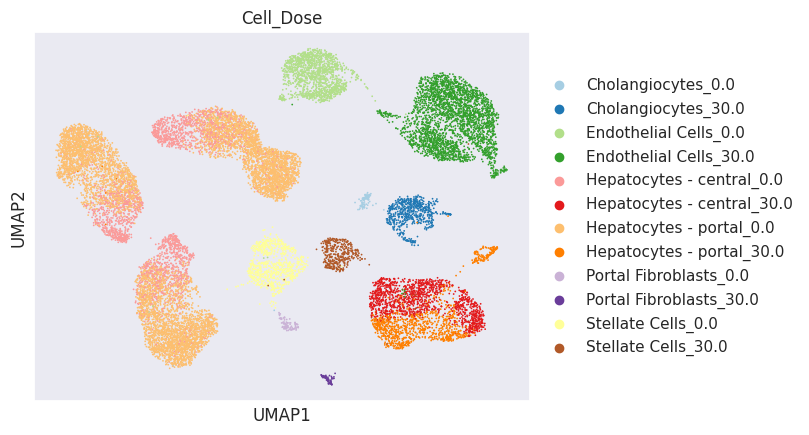

In [41]:
ax = sc.pl.umap(latent_adata, color=['Cell_Dose'], frameon=True,palette = "Paired")

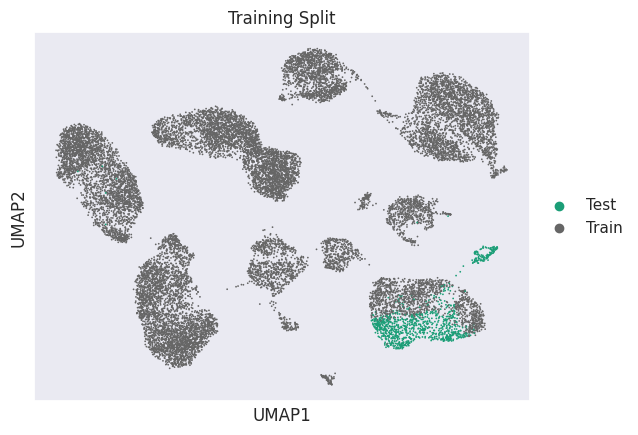

In [42]:
sc.pl.umap(latent_adata, color=['Training Split'], frameon=True,palette ="Dark2")

In [43]:
pred, delta = model.predict(
ctrl_key="0.0",
treat_key="30.0",
cell_type_to_predict=cell,
regression = False)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [44]:
pred

AnnData object with n_obs × n_vars = 2826 × 5000
    obs: 'Dose', 'batch', 'celltype', 'n_counts', 'n_genes', 'condition', 'dose', '_scvi_batch', '_scvi_labels', 'cell_dose'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [45]:
ctrl_adata = adata[((adata.obs['celltype'] == cell) & (adata.obs['condition'] == 'control'))]
stim_adata = adata[((adata.obs['celltype'] == cell) & (adata.obs['condition'] == 'stimulated'))]

In [46]:
ctrl_adata

View of AnnData object with n_obs × n_vars = 7492 × 5000
    obs: 'Dose', 'batch', 'celltype', 'n_counts', 'n_genes', 'condition', 'dose', '_scvi_batch', '_scvi_labels'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_uuid', '_scvi_manager_uuid'

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


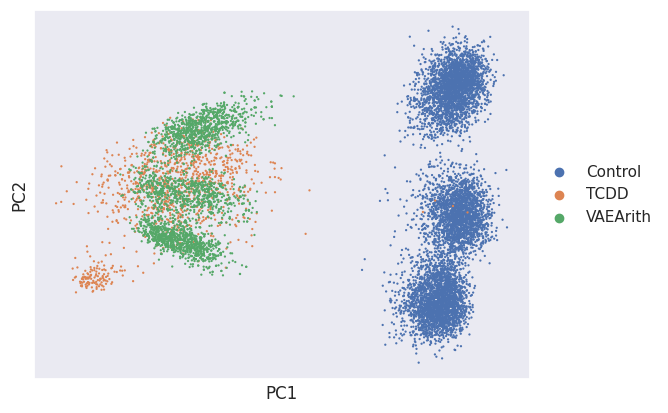

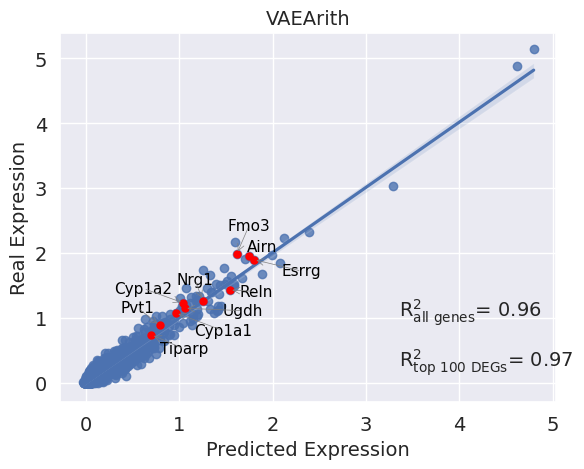

(0.960769611060865, 0.9659741006777395)


In [47]:
pred, delta, reg = model.predict(
ctrl_key="0.0",
treat_key="30.0",
cell_type_to_predict=cell,
regression = True)
pred.obs["dose"] = 'pred'
ctrl_adata = adata[((adata.obs['celltype'] == cell) & (adata.obs["dose"] == "0.0"))]
treat_adata = adata[((adata.obs['celltype'] == cell) & (adata.obs["dose"] == "30.0"))]
eval_adata1 = ctrl_adata.concatenate(treat_adata, pred)
treatments = []
for i in eval_adata1.obs["dose"]:
    if i == "0.0":
        treatments.append("Control")
    elif i == "30.0":
        treatments.append("TCDD")
    else:
        treatments.append("VAEArith")
eval_adata1.obs["Treatment"] = treatments
sc.tl.pca(eval_adata1)
sc.pl.pca(eval_adata1, color = "Treatment", frameon = True, title = "")
CD4T = adata[adata.obs["celltype"] == cell]
sc.tl.rank_genes_groups(CD4T, groupby="dose", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["30.0"]
r2_value = model.reg_mean_plot(
eval_adata1,
axis_keys={"x": "pred", "y": "30.0"},
gene_list=diff_genes[:10],
top_100_genes = diff_genes[:100],
labels={"x": "Predicted Expression", "y": "Real Expression"},
save=False,
show=True,
legend=False, title = "VAEArith")
print(r2_value)

Computing distance edistance


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Computing distance wasserstein
Computing distance euclidean
Computing distance mean_pairwise
Computing distance mmd
saving dotplot to /g/kreshuk/katzalis/repos/thesis/saved_results/scvidr/dotplot.pdf
saving violin plot to /g/kreshuk/katzalis/repos/thesis/saved_results/scvidr/violin.pdf


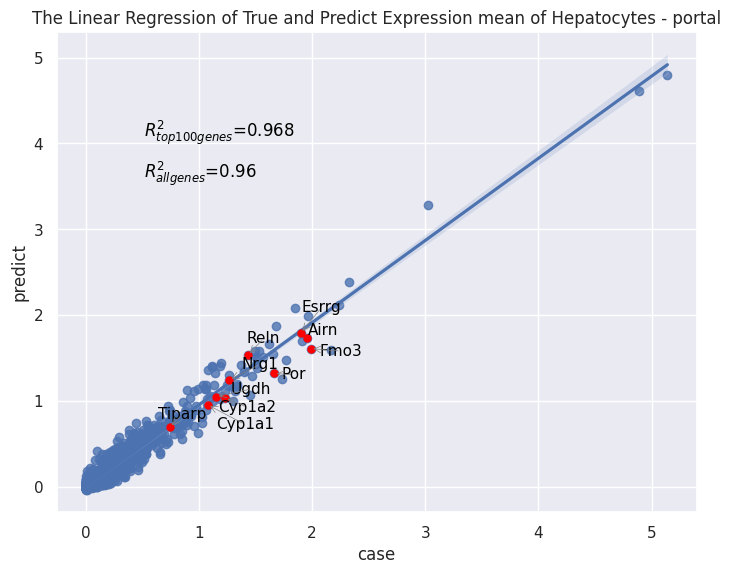

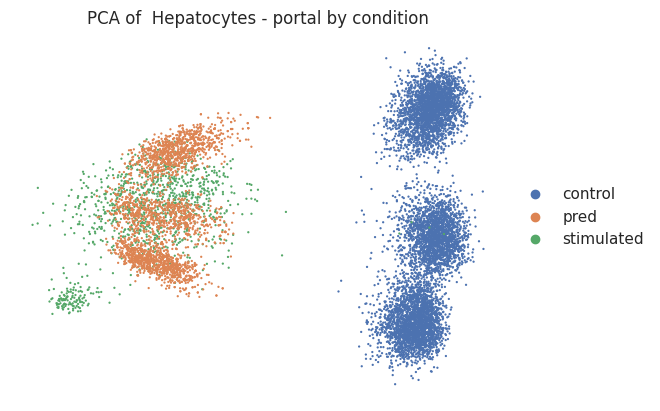

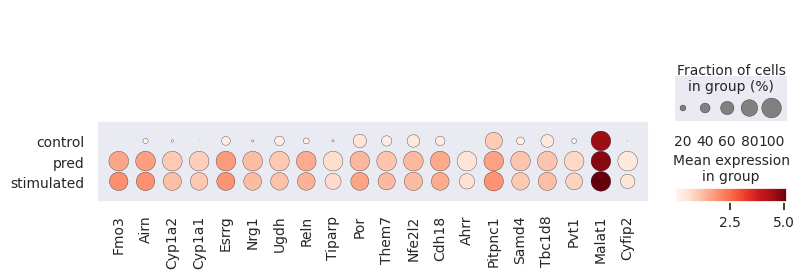

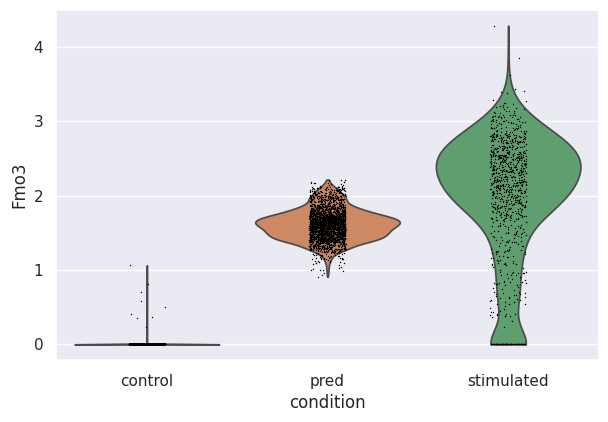

Evaluation figs saved to /g/kreshuk/katzalis/repos/thesis/saved_results/scvidr/evaluation.pdf
Evalution saved /g/kreshuk/katzalis/repos/thesis/saved_results/scvidr/ground_truth
Evalution saved /g/kreshuk/katzalis/repos/thesis/saved_results/scvidr/predicted
Writing metrics to /g/kreshuk/katzalis/repos/thesis/saved_results/scvidr/metrics.csv


AnnData object with n_obs × n_vars = 11320 × 5000
    obs: 'Dose', 'batch', 'celltype', 'n_counts', 'n_genes', 'condition', 'dose', '_scvi_batch', '_scvi_labels'
    uns: 'pca', 'neighbors', 'rank_genes_groups', 'condition_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [48]:
from thesis.utils import FileModelUtils
from thesis.evaluation import evaluation_out_of_sample


model_config = FileModelUtils(
    model_name="VAE_Binary_Prediction_Dioxin_5000g",
    root_path=SAVED_RESULTS_PATH,
    dataset_name="NaultPipeline",
    experiment_name="scvidr",
    perturbation="Dioxin",
    dosages=30.0)


evaluation_out_of_sample(
    model_config=model_config,
    control=ctrl_adata,
    ground_truth=stim_adata,
    predicted=pred,
    output_path=SAVED_RESULTS_PATH / 'scvidr',
    append_metrics=False,
    save_plots=True,
)

## 2. Multi-Dose

In [50]:
from thesis.datasets import NaultPipeline
nault = NaultPipeline()
adata = nault.dataset

Preprocessing started
Preprocessing finished


In [52]:
from vidr.utils import prepare_cont_data

cell_types_of_int = [
    "Hepatocytes - central",
    "Hepatocytes - portal",
    "Cholangiocytes",
    "Stellate Cells",
    "Portal Fibroblasts",
    "Endothelial Cells",
]
adata = adata[adata.obs["celltype"].isin(cell_types_of_int)]
adata.obs["dose"] = [str(i) for i in adata.obs["Dose"]]

# why do they remove the immune cells?

doses = [0.0, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0]
cell = "Hepatocytes - portal"

train_adata, test_adata = prepare_cont_data(
    adata=adata,
    cell_type_key="celltype",
    treatment_key="dose",
    dose_key="Dose",
    cell_type_to_predict=cell,
    control_dose=0.0,
    normalized=True,
)


In [53]:
train_adata.obs.groupby(['celltype', 'dose']).size()

celltype               dose
Cholangiocytes         0.0      101
                       0.01      84
                       0.03      89
                       0.1      131
                       0.3      114
                       1.0       80
                       10.0     168
                       3.0       70
                       30.0     597
Endothelial Cells      0.0     1445
                       0.01     812
                       0.03    1494
                       0.1     1991
                       0.3     1746
                       1.0     2124
                       10.0    1865
                       3.0     1138
                       30.0    2836
Hepatocytes - central  0.0     2486
                       0.01    1482
                       0.03    1775
                       0.1     2902
                       0.3     2276
                       1.0     2603
                       10.0    3729
                       3.0     2429
                       30.0    1325


In [54]:
train = True
model = vidr.VIDR(train_adata, linear_decoder=False)
if train:
    model.train(
        max_epochs=100, batch_size=128, early_stopping=True, early_stopping_patience=25
    )
    model.save(f"{SAVED_RESULTS_PATH}/scvidr/multi_dose", overwrite=True)
else:
    model = model.load(f"{SAVED_RESULTS_PATH}/scvidr/multi_dose", train_adata)

None


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]


Epoch 33/100:  33%|███▎      | 33/100 [02:30<05:04,  4.55s/it, loss=118, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 816.100. Signaling Trainer to stop.


In [56]:
dr_dict, delta, reg = model.predict(
    ctrl_key='0.0',
    treat_key='30.0',
    cell_type_to_predict=cell,
    regression = True,
    continuous = True,
    doses = doses)

[autoreload of thesis.utils failed: Traceback (most recent call last):
  File "/g/kreshuk/katzalis/conda/miniforge3/envs/thesis/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/g/kreshuk/katzalis/conda/miniforge3/envs/thesis/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/g/kreshuk/katzalis/conda/miniforge3/envs/thesis/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/g/kreshuk/katzalis/repos/thesis/thesis/utils.py", line 7, in <module>
    class FileModelUtils:
  File "/g/kreshuk/katzalis/conda/miniforge3/envs/thesis/lib/python3.10/dataclasses.py", line 1175, in

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [ ]:
model_config = FileModelUtils(
    model_name="VAE_Binary_Prediction_Dioxin_5000g",
    root_path=SAVED_RESULTS_PATH,
    dataset_name="NaultPipeline",
    experiment_name="scvidr",
    perturbation="Dioxin",
    dosages=30.0,
)

ctrl_adata = adata[((adata.obs["celltype"] == cell) & (adata.obs["Dose"] == 0))]
for d in doses[1:]:
    stim_adata = adata[((adata.obs["celltype"] == cell) & (adata.obs["Dose"] == d))]
    evaluation_out_of_sample(
        model_confg=model_config,
        control=ctrl_adata,
        ground_truth=stim_adata,
        predicted=dr_dict[d],
        output_path=SAVED_RESULTS_PATH / "scvidr" / "multi_dose",
        append_metrics=False,
        save_plots=True
    )